# Mount GCS buckets

make sure to run mount_gcsbucket.ipynb first!

# Sample Notebook for Zero-Shot Inference with CheXzero
This notebook walks through how to use CheXzero to perform zero-shot inference on a chest x-ray image dataset.

## Import Libraries

In [20]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Optional
import math
from sklearn import metrics
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from eval import evaluate, bootstrap
from zero_shot import make, make_true_labels, run_softmax_eval

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Directories and Constants

In [2]:
## Define Zero Shot Labels and Templates

# ----- DIRECTORIES ------ #
cxr_filepath: str = '../data/chexpert-test/chexpert-test/chexlocalize/CheXpert/chexpert_test.h5' # filepath of chest x-ray images (.h5)
cxr_true_labels_path: Optional[str] = '../data/chexpert-test/groundtruth.csv' # (optional for evaluation) if labels are provided, provide path
model_dir: str = '../data/chexzero/models' # where pretrained models are saved (.pt) 
predictions_dir: Path = Path('../data/chexzero/predictions') # where to save predictions
cache_dir: str = predictions_dir / "cached" # where to cache ensembled predictions

context_length: int = 77

# ------- LABELS ------  #
# Define labels to query each image | will return a prediction for each label
cxr_labels: List[str] = ['Atelectasis','Cardiomegaly', 
                                      'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
                                      'Lung Opacity', 'No Finding','Pleural Effusion', 'Pleural Other', 'Pneumonia', 
                                      'Pneumothorax', 'Support Devices']

# ---- TEMPLATES ----- # 
# Define set of templates | see Figure 1 for more details                        
cxr_pair_template: Tuple[str] = ("{}", "no {}")

# ----- MODEL PATHS ------ #
# If using ensemble, collect all model paths
model_paths = []
for subdir, dirs, files in os.walk(model_dir):
    for file in files:
        full_dir = os.path.join(subdir, file)
        model_paths.append(full_dir)
        
print(model_paths)

['../data/chexzero/models/best_128_0.0002_original_15000_0.859.pt', '../data/chexzero/models/best_128_0.0002_original_8000_0.857.pt', '../data/chexzero/models/best_128_5e-05_original_22000_0.855.pt', '../data/chexzero/models/best_64_0.0001_original_16000_0.861.pt', '../data/chexzero/models/best_64_0.0001_original_17000_0.863.pt', '../data/chexzero/models/best_64_0.0001_original_35000_0.864.pt', '../data/chexzero/models/best_64_0.0002_original_23000_0.854.pt', '../data/chexzero/models/best_64_5e-05_original_16000_0.858.pt', '../data/chexzero/models/best_64_5e-05_original_18000_0.862.pt', '../data/chexzero/models/best_64_5e-05_original_22000_0.864.pt']


## Run Inference

In [3]:
## Run the model on the data set using ensembled models
def ensemble_models(
    model_paths: List[str], 
    cxr_filepath: str, 
    cxr_labels: List[str], 
    cxr_pair_template: Tuple[str], 
    cache_dir: str = None, 
    save_name: str = None,
) -> Tuple[List[np.ndarray], np.ndarray]: 
    """
    Given a list of `model_paths`, ensemble model and return
    predictions. Caches predictions at `cache_dir` if location provided.

    Returns a list of each model's predictions and the averaged
    set of predictions.
    """

    predictions = []
    model_paths = sorted(model_paths) # ensure consistency of 
    for path in model_paths: # for each model
        model_name = Path(path).stem

        # load in model and `torch.DataLoader`
        model, loader = make(
            model_path=path, 
            cxr_filepath=cxr_filepath, 
        ) 
        
        # path to the cached prediction
        if cache_dir is not None:
            if save_name is not None: 
                cache_path = Path(cache_dir) / f"{save_name}_{model_name}.npy"
            else: 
                cache_path = Path(cache_dir) / f"{model_name}.npy"

        # if prediction already cached, don't recompute prediction
        if cache_dir is not None and os.path.exists(cache_path): 
            print("Loading cached prediction for {}".format(model_name))
            y_pred = np.load(cache_path)
        else: # cached prediction not found, compute preds
            print("Inferring model {}".format(path))
            y_pred = run_softmax_eval(model, loader, cxr_labels, cxr_pair_template)
            if cache_dir is not None: 
                Path(cache_dir).mkdir(exist_ok=True, parents=True)
                np.save(file=cache_path, arr=y_pred)
        predictions.append(y_pred)
    
    # compute average predictions
    y_pred_avg = np.mean(predictions, axis=0)
    
    return predictions, y_pred_avg

In [4]:
predictions, y_pred_avg = ensemble_models(
    model_paths=model_paths, 
    cxr_filepath=cxr_filepath, 
    cxr_labels=cxr_labels, 
    cxr_pair_template=cxr_pair_template, 
    cache_dir=cache_dir,
)

Loading cached prediction for best_128_0.0002_original_15000_0.859
Loading cached prediction for best_128_0.0002_original_8000_0.857
Loading cached prediction for best_128_5e-05_original_22000_0.855
Loading cached prediction for best_64_0.0001_original_16000_0.861
Loading cached prediction for best_64_0.0001_original_17000_0.863
Loading cached prediction for best_64_0.0001_original_35000_0.864
Loading cached prediction for best_64_0.0002_original_23000_0.854
Loading cached prediction for best_64_5e-05_original_16000_0.858
Loading cached prediction for best_64_5e-05_original_18000_0.862
Loading cached prediction for best_64_5e-05_original_22000_0.864


In [5]:
# save averaged preds
pred_name = "chexpert_preds.npy" # add name of preds
predictions_dir = predictions_dir / pred_name
np.save(file=predictions_dir, arr=y_pred_avg)

## (Optional) Evaluate Results
If ground truth labels are available, compute AUC on each pathology to evaluate the performance of the zero-shot model. 

In [6]:
# make test_true
test_pred = y_pred_avg
test_true = make_true_labels(cxr_true_labels_path=cxr_true_labels_path, cxr_labels=cxr_labels)

# evaluate model
cxr_results = evaluate(test_pred, test_true, cxr_labels)

# boostrap evaluations for 95% confidence intervals
bootstrap_results = bootstrap(test_pred, test_true, cxr_labels)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
# display AUC with confidence intervals
bootstrap_results[1]

,Atelectasis_auc,Cardiomegaly_auc,Consolidation_auc,Edema_auc,Enlarged Cardiomediastinum_auc,Fracture_auc,Lung Lesion_auc,Lung Opacity_auc,No Finding_auc,Pleural Effusion_auc,Pleural Other_auc,Pneumonia_auc,Pneumothorax_auc,Support Devices_auc
mean,0.8103,0.9147,0.8892,0.8979,0.9157,0.5607,0.7401,0.9197,0.0769,0.9315,0.5923,0.7749,0.6422,0.7659
lower,0.7708,0.8867,0.8193,0.8649,0.8907,0.2582,0.5773,0.8943,0.0504,0.9049,0.4533,0.5666,0.4720,0.7237
upper,0.8458,0.9374,0.9457,0.9281,0.9375,0.8708,0.8788,0.9412,0.1043,0.9535,0.8838,0.9406,0.8211,0.8047


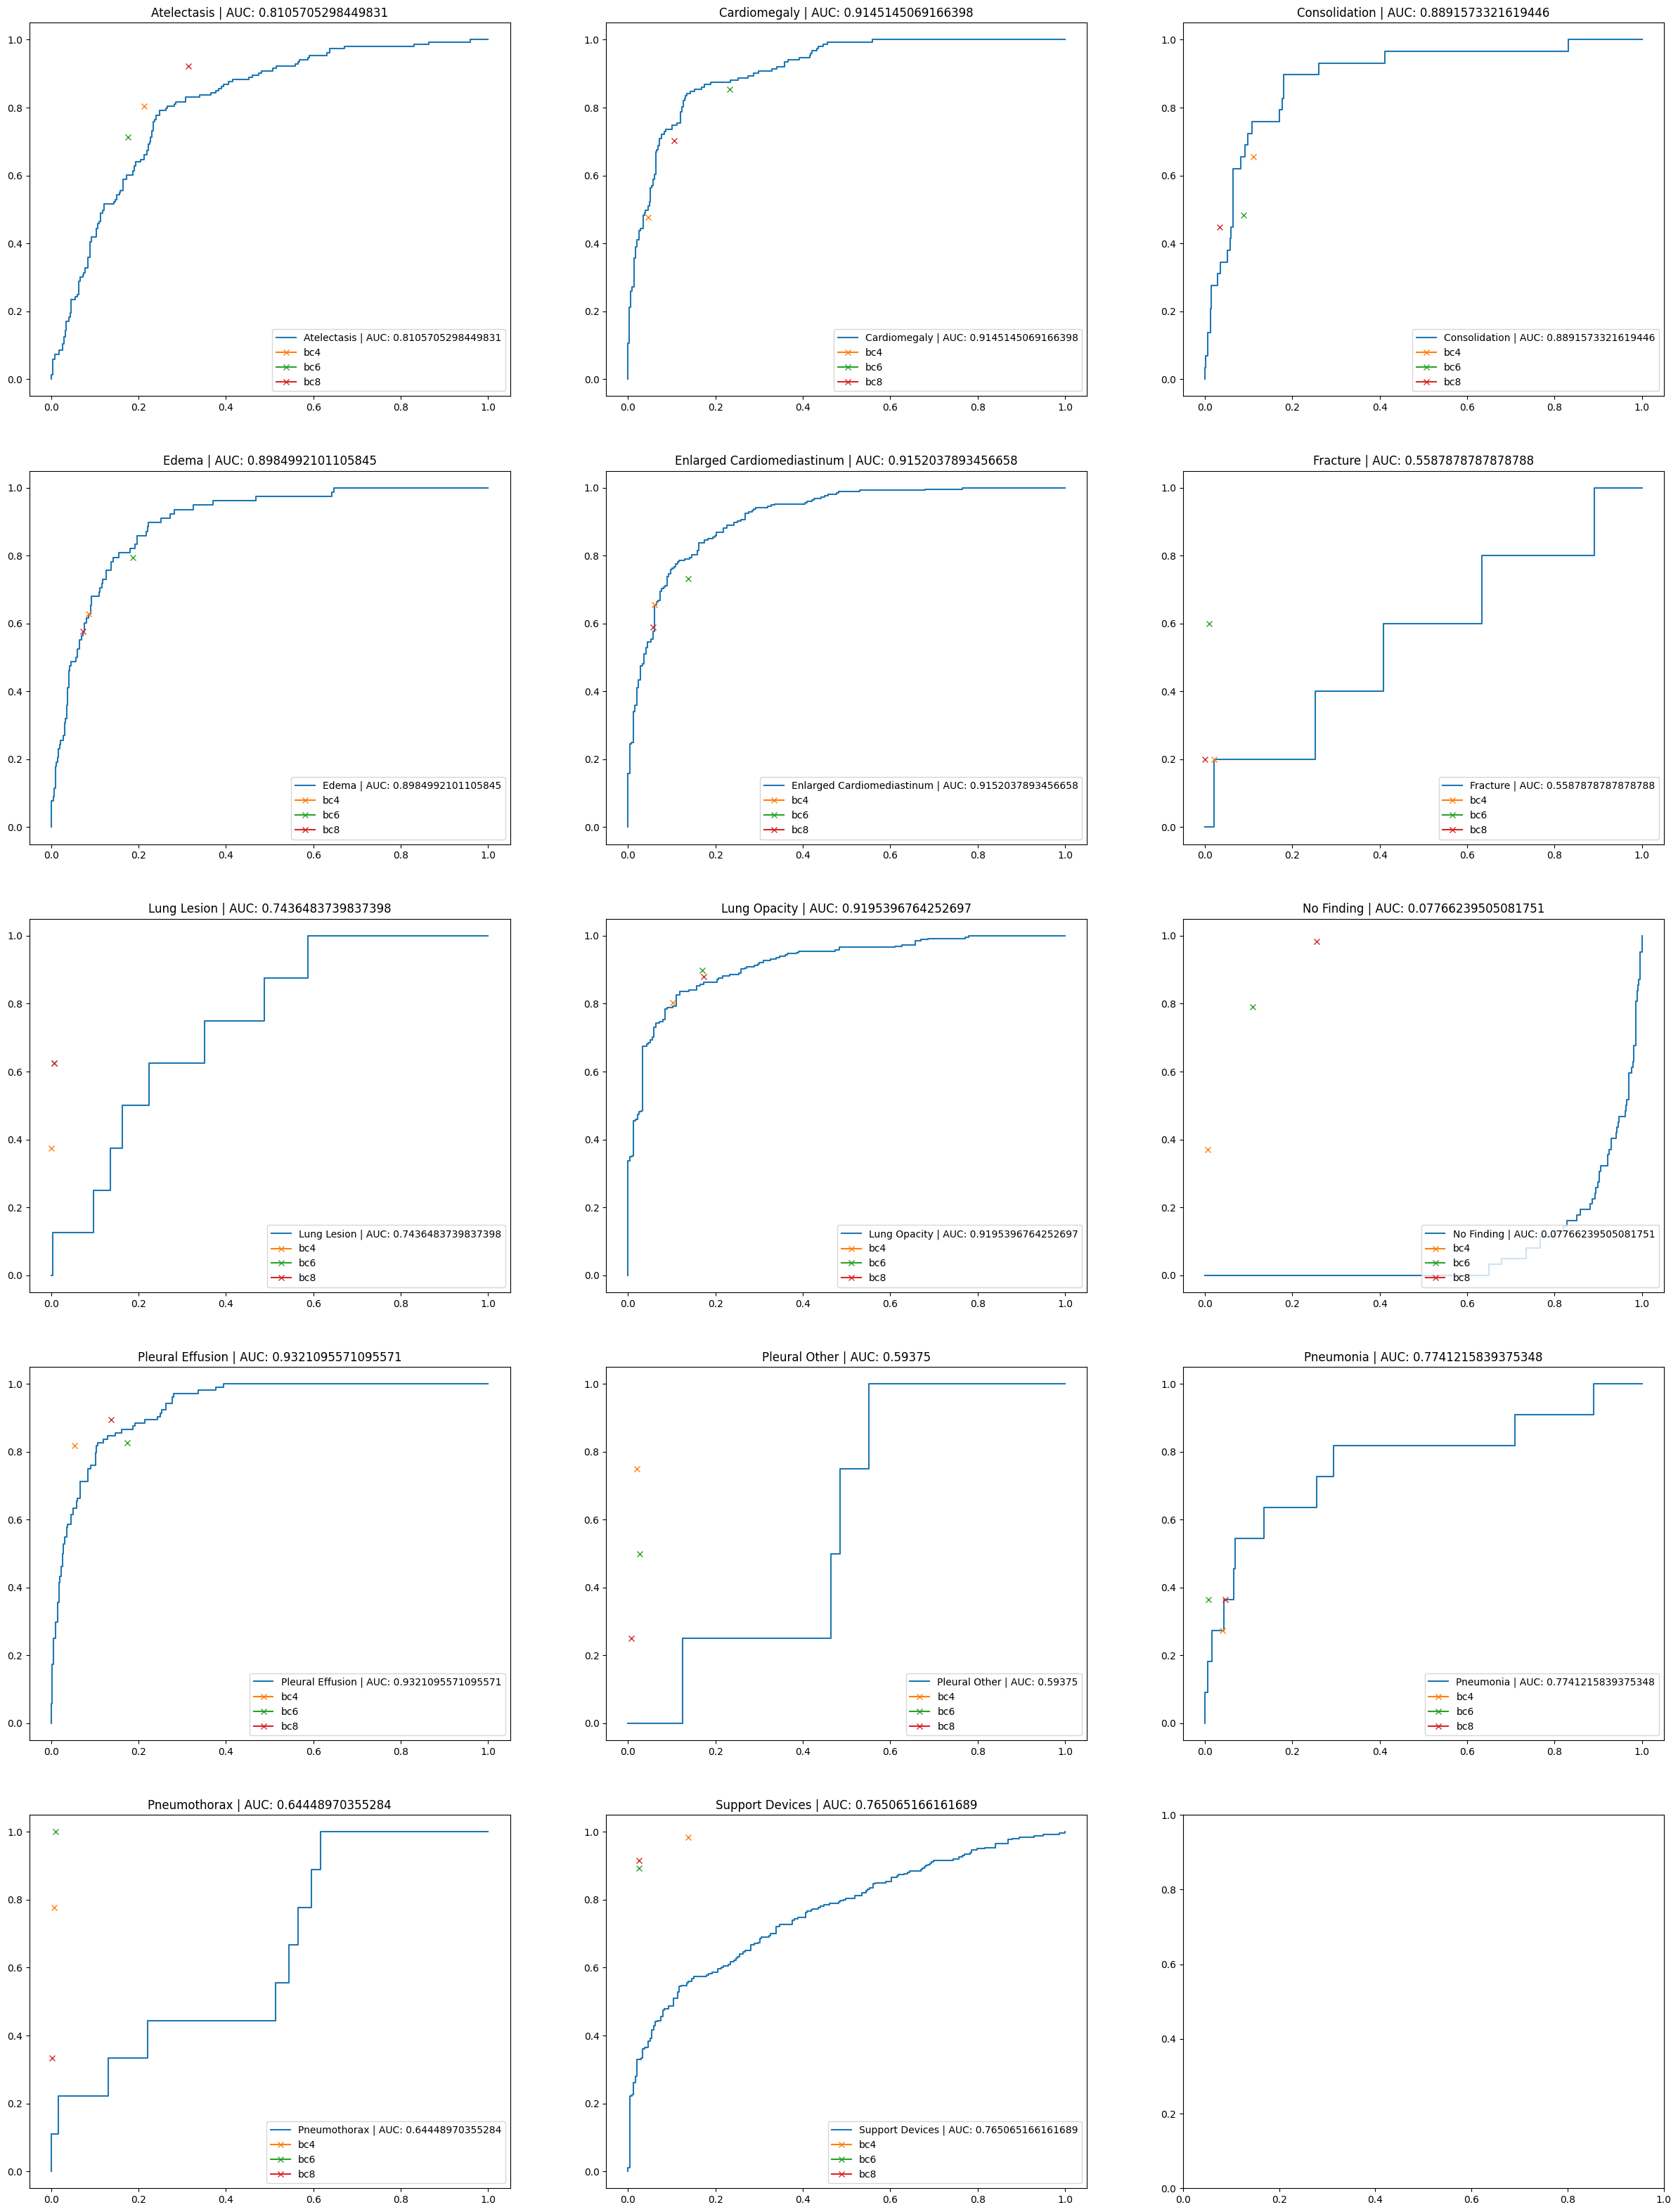

In [49]:
# plot results with benchmark radiologists

benchmarks = {}
benchmark_names = ['bc4', 'bc6', 'bc8']
benchmark_paths = [f'../data/chexpert-test/{bname}.csv' for bname in benchmark_names]
groundtruth = pd.read_csv('../data/chexpert-test/groundtruth.csv')
for bname, bpath in zip(benchmark_names, benchmark_paths):
    df_ = pd.read_csv(bpath)
    df_ = df_.set_index('Study').loc[groundtruth['Study']]    # align index
    df_ = df_[cxr_labels]
    benchmarks[bname] = df_.values

ncol = 3
nrow = math.ceil(test_pred.shape[-1]/ncol)
fig, axs = plt.subplots(nrow, ncol, figsize=(30, 40))

for i in range(nrow):
    for j in range (ncol):
        idx = i*ncol + j
        if idx >= test_pred.shape[-1]:
            break
        fpr, tpr, _ = metrics.roc_curve(test_true[:, idx], test_pred[:, idx])
        auc = metrics.roc_auc_score(test_true[:, idx], test_pred[:, idx])
        axs[i, j].plot(fpr, tpr, label=f"{cxr_labels[idx]} | AUC: {auc}")
        
        # plot benchmarks
        for bname, benchmark in benchmarks.items():
            fp = np.sum(np.logical_and(np.isclose(test_true[:, idx], 0), np.isclose(benchmark[:, idx], 1)))
            fpr = fp/(1-test_true[:, idx]).sum()
            tp = np.sum(test_true[:, idx] * benchmark[:, idx])
            tpr = tp/test_true[:, idx].sum()
            axs[i, j].plot(fpr, tpr, marker='x', label=bname)
        
        axs[i, j].legend(loc=4)
        axs[i, j].set_title(f"{cxr_labels[idx]} | AUC: {auc}")
plt.show()

In [40]:
benchmarks

{'bc4': array([[0, 1, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 1],
        [1, 0, 1, ..., 0, 0, 1]]),
 'bc6': array([[1, 1, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 1],
        [1, 1, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 1]]),
 'bc8': array([[1, 1, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [1, 1, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 1]])}

In [48]:
x = np.array([0.00000001, 0.00000001])
np.isclose(x, 0)

array([ True,  True])